<a href="https://colab.research.google.com/github/rrfsantos/Desafios-NLP/blob/main/RedesRecorrentesDoencasPulmonares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network - LSTM


## Parte 1 - Preprocessamento de Dados

### Importar as bibliotecas

In [ ]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

TensorFlow 1.x selected.


### Importar a base de dados

In [ ]:
dataset_train = pd.read_csv('/content/train.csv')
training_set = dataset_train.iloc[:, 1:2].values #só coluna da série em si

### gráfico da série temporal

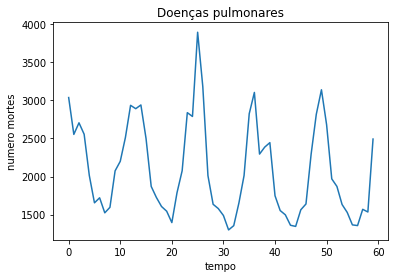

In [ ]:
plt.plot(training_set)
plt.xlabel("Tempo")
plt.ylabel("Mortes")
plt.title("Doenças pulmonares")
plt.show()

### Normalização para input no modelo

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [ ]:
window = 10
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [ ]:
X_train.shape

(50, 10)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
X_train.shape

(50, 10, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


### Construção da Rede completa

In [ ]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 48, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = False))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
#regressor.add(LSTM(units = 50))
#regressor.add(Dropout(0.2))

# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 48)            9600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 48)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                41280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 81        
Total params: 50,961
Trainable params: 50,961
Non-trainable params: 0
_________________________________________________________________


### Treinamento

In [ ]:
regressor.fit(X_train, y_train, epochs = 200, batch_size = 32)


Epoch 1/200
50/50 [==============================] - 1s 14ms/step - loss: 0.1444
Epoch 2/200
50/50 [==============================] - 0s 655us/step - loss: 0.1141
Epoch 3/200
50/50 [==============================] - 0s 658us/step - loss: 0.0891
Epoch 4/200
50/50 [==============================] - 0s 706us/step - loss: 0.0810
Epoch 5/200
50/50 [==============================] - 0s 658us/step - loss: 0.0838
Epoch 6/200
50/50 [==============================] - 0s 642us/step - loss: 0.0835
Epoch 7/200
50/50 [==============================] - 0s 683us/step - loss: 0.0766
Epoch 8/200
50/50 [==============================] - 0s 660us/step - loss: 0.0722
Epoch 9/200
50/50 [==============================] - 0s 683us/step - loss: 0.0741
Epoch 10/200
50/50 [==============================] - 0s 748us/step - loss: 0.0722
Epoch 11/200
50/50 [==============================] - 0s 677us/step - loss: 0.0707
Epoch 12/200
50/50 [==============================] - 0s 706us/step - loss: 0.0705
Epoch 13/200


## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [ ]:
dataset_test = pd.read_csv('test.csv')
test_pul = dataset_test.iloc[:, 1:2].values

### Construir a estrutura para teste

In [ ]:
dataset_total = pd.concat((dataset_train.iloc[:,1], dataset_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [ ]:
predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

### Visualizar os resultados de treino e teste

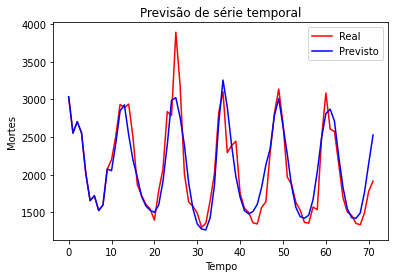

In [ ]:
allTargetData = np.vstack((training_set, test_pul))
training_predicted = regressor.predict(X_train)
training_predicted = sc.inverse_transform(training_predicted)
allForecastedData = np.vstack((training_set[0:window], training_predicted, predicted))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Mortes')
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [ ]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_pul, predicted))
print('RMSE: ', rmse)

RMSE:  259.5260067158582


In [ ]:
mse = mean_squared_error(test_pul, predicted)
print('MSE: ',mse)

MSE:  67353.74816187967


In [ ]:
mape = np.mean(np.abs((test_pul - predicted) / test_pul)) * 100
print('MAPE: ',mape, '%')

MAPE:  10.787926678252218 %


In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test_pul, predicted)
print('MAE: ',mae)

MAE:  204.87699381510416
